In [3]:
import sys

import pims
import pandas as pd
import numpy as np
import torch
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage

sys.path.append('../')
from test import upsample_bic, upsample_tensor
from model import LapSRN

In [4]:
df = pd.read_excel('../../data/raw/intraoperative/annot.xlsx', index_col='frame')
print(len(df))
df.head()

200


,uid,Tool,video,x1,y1,x2,y2,x3,y3,x4,y4
frame,,,,,,,,,,,
14208,1,1,2012-07-26_102742.avi,1037.7020,550.2272,1095.353,482.7273,1090.339,593.1818,1178.068,750.6818
14209,2,1,2012-07-26_102742.avi,1014.7430,564.9899,1065.480,504.1449,1065.480,604.1046,1153.602,775.7747
14210,3,1,2012-07-26_102742.avi,1000.1040,585.0000,1055.248,519.5455,1062.768,619.7727,1145.483,779.3182
14211,4,1,2012-07-26_102742.avi,987.5718,568.6364,1042.715,505.2273,1047.729,613.6364,1117.911,754.7727
14212,5,1,2012-07-26_102742.avi,985.0653,564.5455,1040.209,499.0909,1050.235,605.4545,1155.509,785.4545


Frame([[[0, 0, 0],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [2, 2, 2],
        [1, 1, 1],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[1, 1, 1],
        [2, 2, 2],
        [1, 1, 1],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[1, 1, 1],
        [2, 2, 2],
        [1, 1, 1],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]], dtype=uint8)
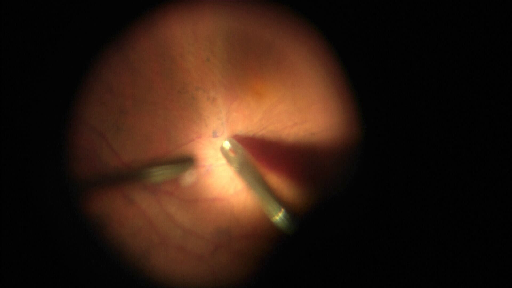

In [30]:
video_file = '../../data/raw/intraoperative/video.avi'

v = pims.Video(video_file)

idx = df.index[140]
frame = v[idx]
x1, y1, x2, y2, x3, y3, x4, y4 = (df.loc[idx, ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']]).astype(int)
x_min, x_max = np.min([x1, x2, x3, x4]), np.max(([x1, x2, x3, x4]))
y_min, y_max = np.min([y1, y2, y3, y4]), np.max(([y1, y2, y3, y4]))

offset = 150
x_min = x1
x_max = x1
y_min = y1
y_max = y1
x_min, y_min = np.maximum([0, 0], [x_min - offset, y_min - offset])
x_max, y_max = np.minimum(frame.shape[0:2], [x_max + offset, y_max + offset])
x_max - x_min, y_max - y_min

frame
#Image.fromarray(frame).save('frame_full.jpg')

(1080, 1920, 3)
(300, 300)


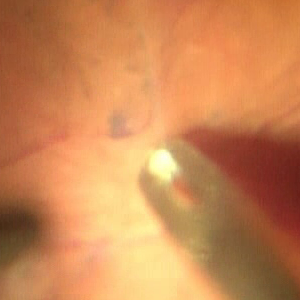

In [31]:
region = Image.fromarray(frame[y_min:y_max, x_min:x_max, :])
print(frame.shape)
print(region.size)
region.save("frame.jpg")
region

In [32]:
#checkpoint = torch.load('../../best_checkpoints/l1.pt')
checkpoint = torch.load('../../checkpoints_camp/srn_333.pt')
model = LapSRN(depth=10).cuda()
model.load_state_dict(checkpoint['model_state'])

In [33]:
from PIL.ImageFilter import GaussianBlur
to_tensor = ToTensor()
to_pil = ToPILImage()

#lr = to_tensor(region)

elapsed_time, hr2_sr, hr4_sr = upsample_tensor(model=model, lr=region, return_time=True, to_normalize=True)
hr2_sr, hr4_sr = to_pil(hr2_sr), to_pil(hr4_sr)
hr2_bic, hr4_bic = upsample_bic(region)

hr4_sr.save('sr_frame.jpg')
hr4_bic.save('bic_frame.jpg')

In [34]:
elapsed_time

0.0055450710005970905

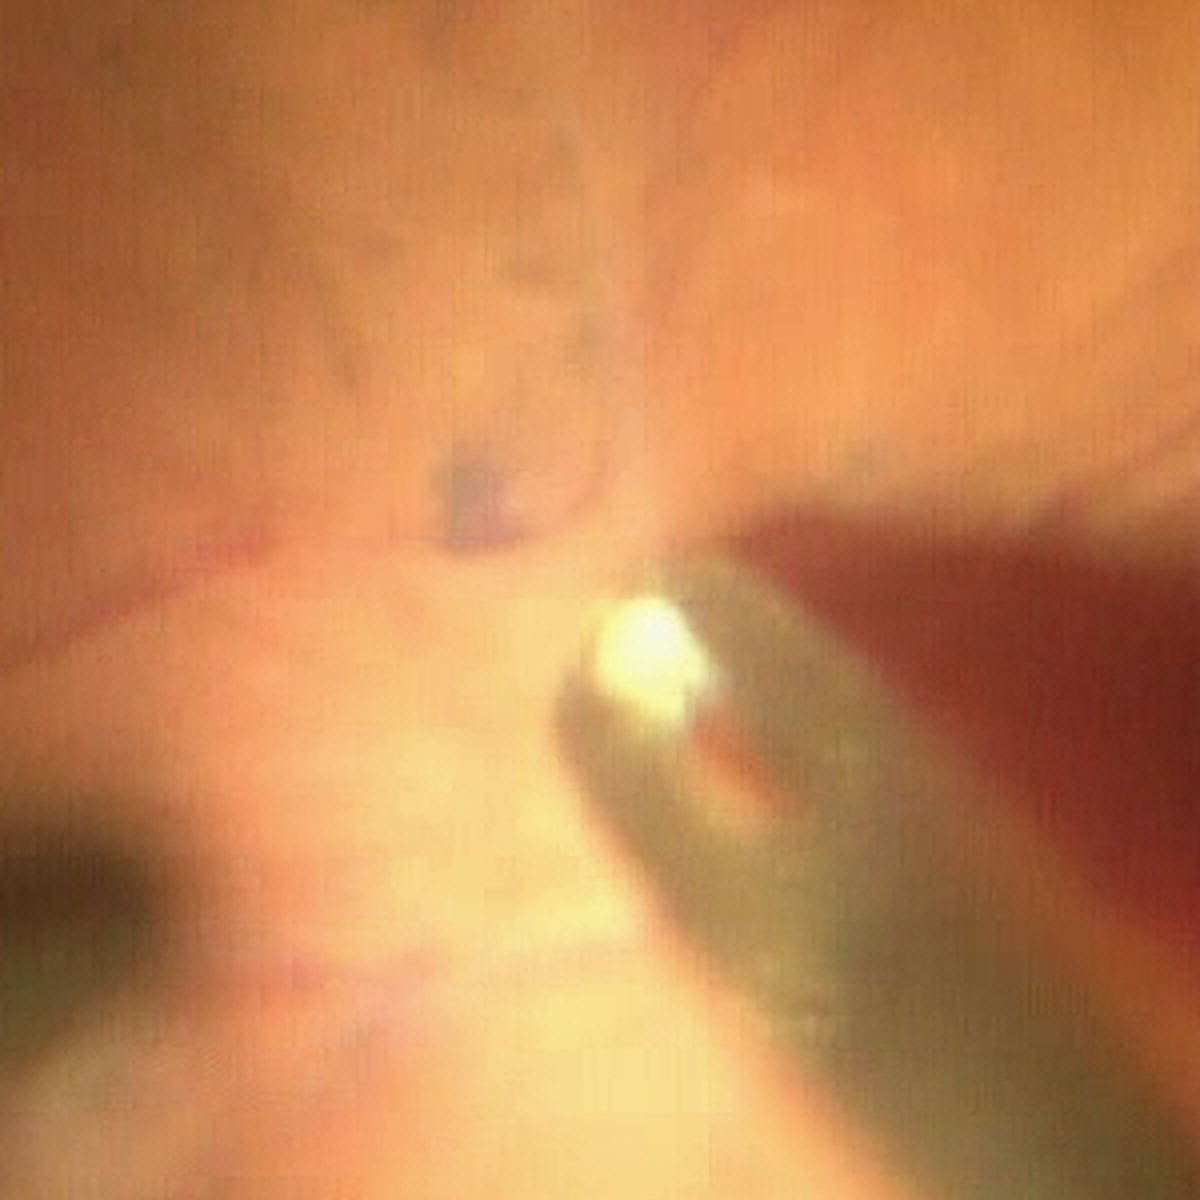

In [35]:
hr4_sr

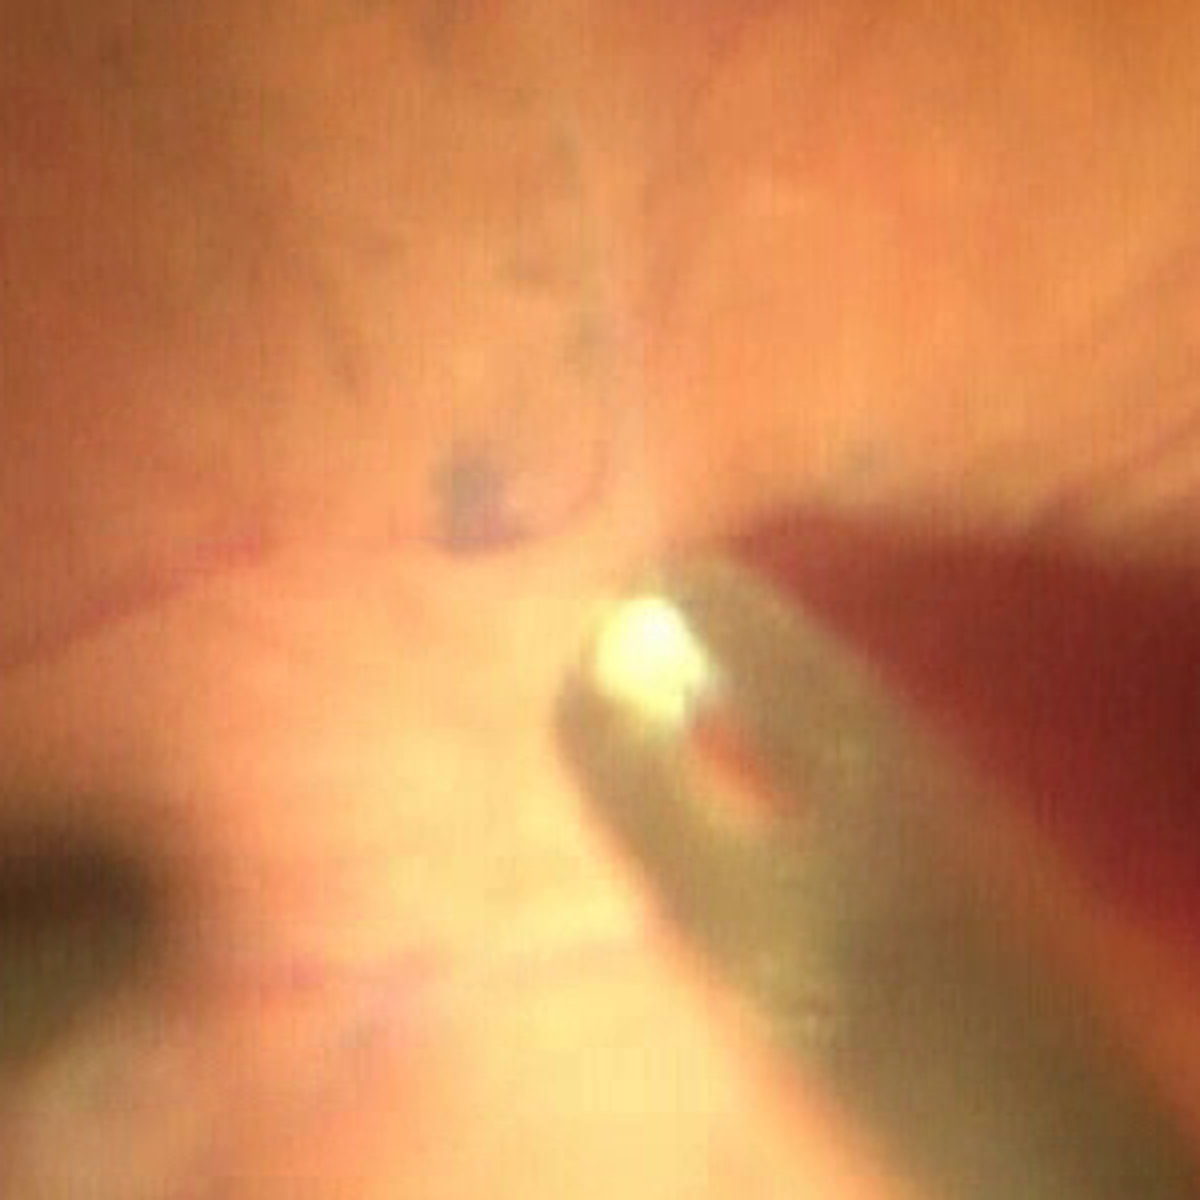

In [36]:
hr4_bic

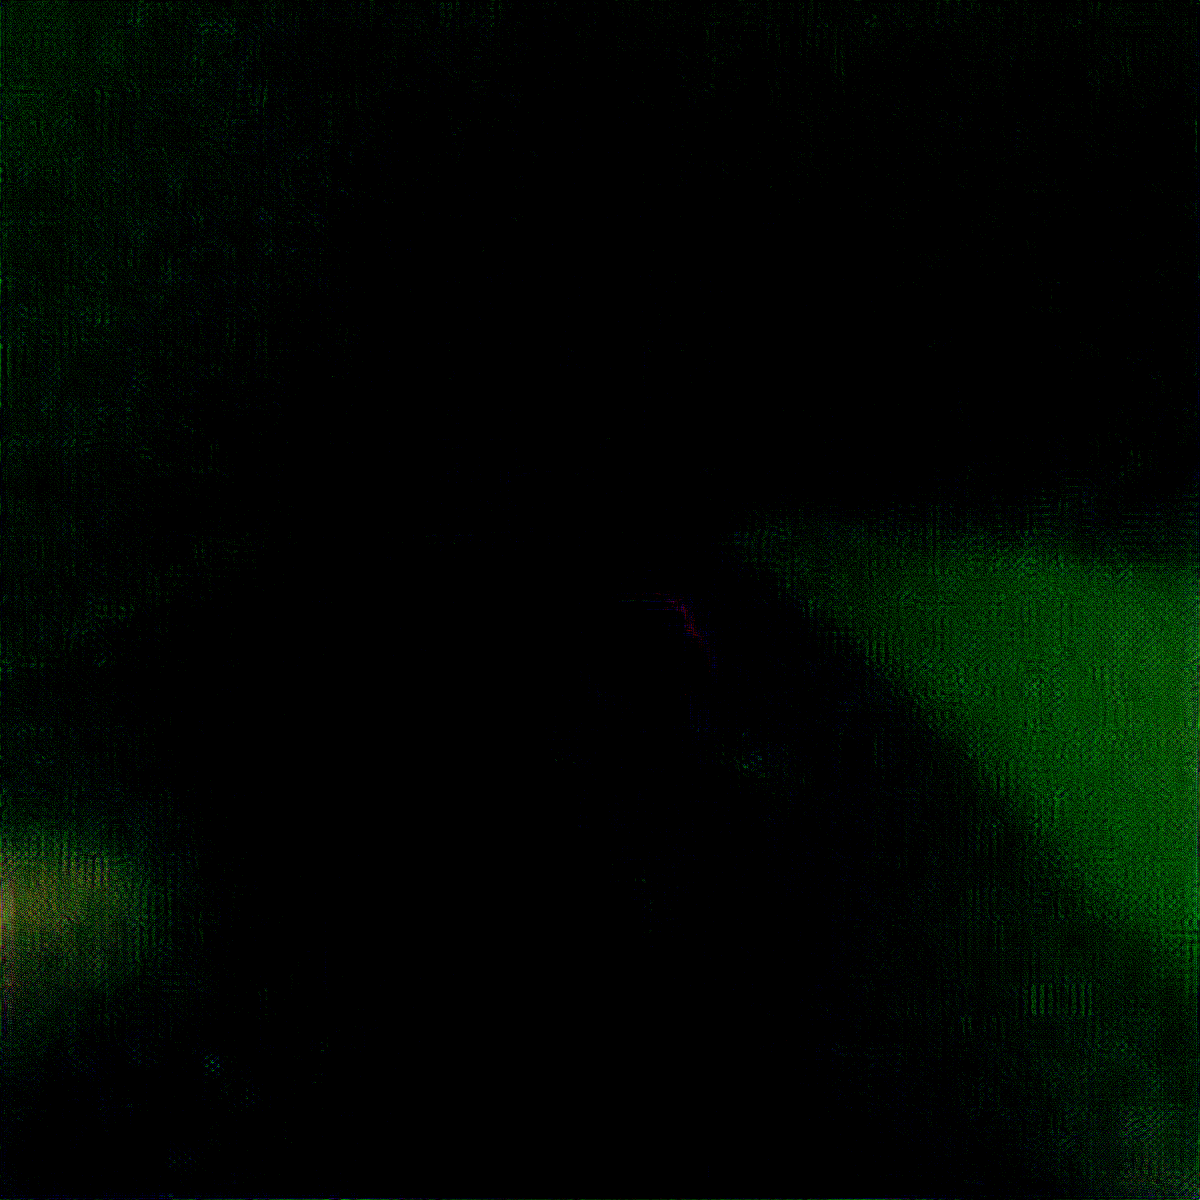

In [37]:
from test import residual
residual(hr4_sr, hr4_bic)